<a href="https://colab.research.google.com/github/Pradeep-Panchariya/Restful_API/blob/main/Restful_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

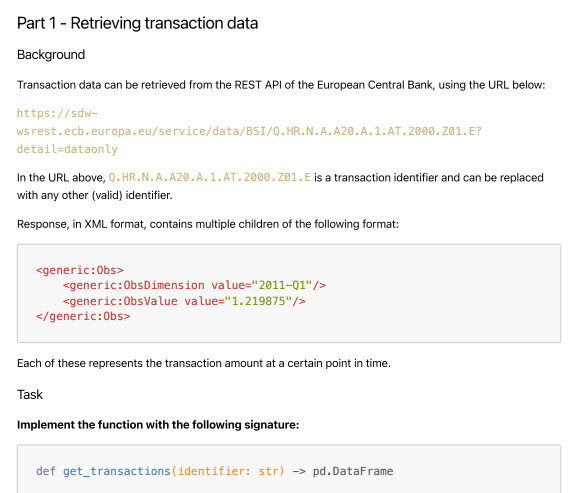



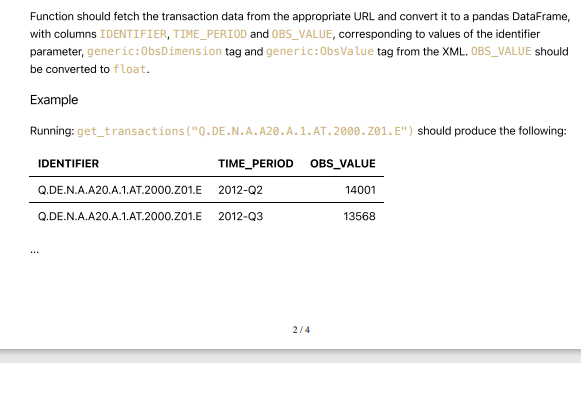


# **@Author**: Pradeep Panchariya

## **@Email** : panchariya11@gmail.com

In [ ]:
import requests, json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import urllib.request
import pandas as pd
import lxml
import numpy as np

In [ ]:
url = "https://sdw-wsrest.ecb.europa.eu/service/data/BSI/Q.HR.N.A.A20.A.1.AT.2000.Z01.E?detail=dataonly"

In [ ]:
def get_transacation(identifier:str):
  url = "https://sdw-wsrest.ecb.europa.eu/service/data/BSI/"
  #Parameter to pass for query (?)
  params = {'detail':'dataonly'}
  url = url + identifier
  response = requests.get(url, params = params)
  bs = BeautifulSoup(response.text,'xml')
  dic = {}
  dic['IDENTIFIER']=[]
  dic['TIME_PERIOD'] = []
  dic['OBS_VALUE'] = []
  for date,amount in zip(bs.find_all('generic:ObsDimension'),bs.find_all('generic:ObsValue')):
      dic['IDENTIFIER'].append(identifier)
      dic['TIME_PERIOD'].append(date.get('value'))
      dic['OBS_VALUE'].append(amount.get('value'))
  
  df = pd.DataFrame(dic)
  return df

result = get_transacation('Q.DE.N.A.A20.A.1.AT.2000.Z01.E')
print(result)

                        IDENTIFIER TIME_PERIOD OBS_VALUE
0   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2012-Q2     14001
1   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2012-Q3     13568
2   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2012-Q4     13433
3   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2013-Q1     13838
4   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2013-Q2     13769
5   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2013-Q3     13966
6   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2013-Q4     14127
7   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2014-Q1     14474
8   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2014-Q2     15420
9   Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2014-Q3     15752
10  Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2014-Q4     18213
11  Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2015-Q1     17514
12  Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2015-Q2     18458
13  Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2015-Q3     18687
14  Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2015-Q4     19254
15  Q.DE.N.A.A20.A.1.AT.2000.Z01.E     2016-Q1     20301
16  Q.DE.N.A.A20.A.1.AT.2000.Z0

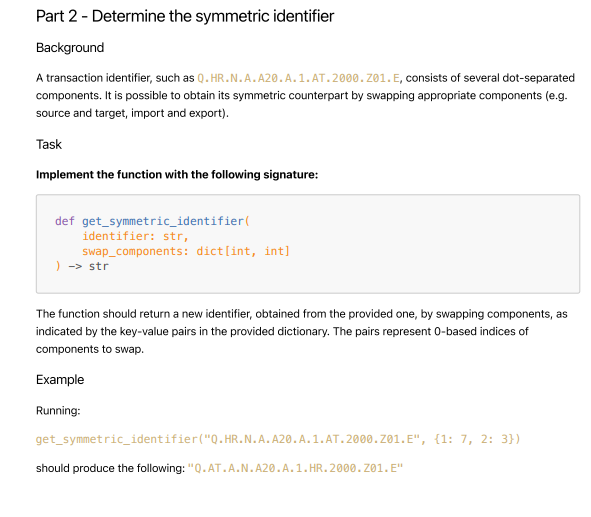

In [ ]:
def get_symmetric_identifier(identifier: str,swap_components) -> str:
  #split the word by .
  identifier_split = identifier.split('.')
  for k,v in swap_components.items():
    identifier_split[k],identifier_split[v] = identifier_split[v],identifier_split[k]
  join_identifier = '.'.join(identifier_split)
  return join_identifier
result = get_symmetric_identifier("Q.HR.N.A.A20.A.1.AT.2000.Z01.E",{1:7,2:3})
print(result)

Q.AT.A.N.A20.A.1.HR.2000.Z01.E


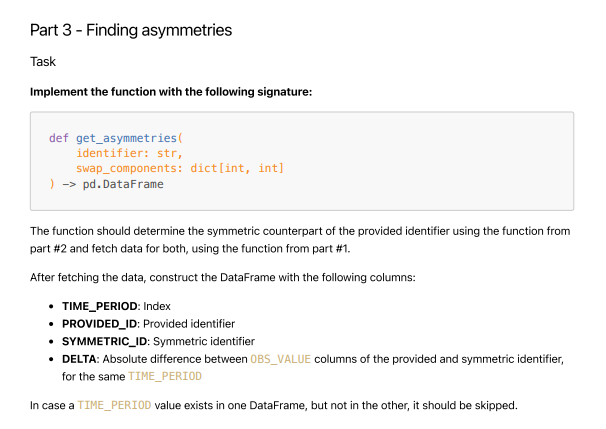

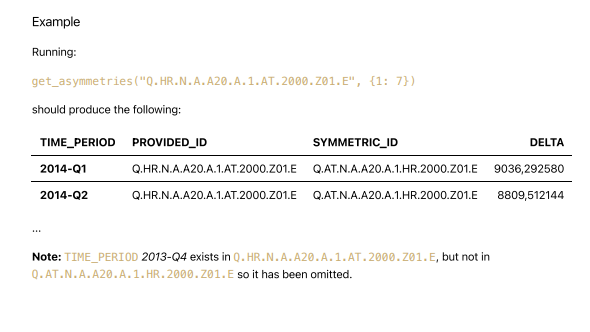

In [ ]:
def get_asymmetries(identifier: str,swap_components) :
  symetric = get_symmetric_identifier(identifier,swap_components)
  provided = get_transacation(identifier)
  sym      = get_transacation(symetric)
  #Rename the column as per description
  provided.rename(columns={'IDENTIFIER':'PROVIDED_ID'},inplace=True)
  sym.rename(columns={'IDENTIFIER':'SYMMETRIC_ID'},inplace=True)

  #Joining the both the dataframe by TIME_PERIOD 
  cleaned_df = pd.merge(provided,sym,on='TIME_PERIOD',how='inner')
  #Set the index
  cleaned_df = cleaned_df.set_index('TIME_PERIOD')

  #Convert the data type for numerical calcualtion
  cleaned_df['OBS_VALUE_x'] = cleaned_df['OBS_VALUE_x'].astype(float)
  cleaned_df['OBS_VALUE_y'] = cleaned_df['OBS_VALUE_y'].astype(float)
  
  cleaned_df['DELTA'] = abs(cleaned_df['OBS_VALUE_x']-cleaned_df['OBS_VALUE_y'])
  cleaned_df.drop(columns=['OBS_VALUE_x','OBS_VALUE_y'],inplace=True)
  cleaned_df.loc[:, "DELTA"] = cleaned_df["DELTA"].map('{:,f}'.format)
  return cleaned_df

result = get_asymmetries("Q.HR.N.A.A20.A.1.AT.2000.Z01.E",{1:7})
result

,PROVIDED_ID,SYMMETRIC_ID,DELTA
TIME_PERIOD,,,
2013-Q3,Q.HR.N.A.A20.A.1.AT.2000.Z01.E,Q.AT.N.A.A20.A.1.HR.2000.Z01.E,"8,866.696900"
2013-Q4,Q.HR.N.A.A20.A.1.AT.2000.Z01.E,Q.AT.N.A.A20.A.1.HR.2000.Z01.E,"8,875.099521"
2014-Q1,Q.HR.N.A.A20.A.1.AT.2000.Z01.E,Q.AT.N.A.A20.A.1.HR.2000.Z01.E,"9,036.292579"
2014-Q2,Q.HR.N.A.A20.A.1.AT.2000.Z01.E,Q.AT.N.A.A20.A.1.HR.2000.Z01.E,"8,809.512144"
2014-Q3,Q.HR.N.A.A20.A.1.AT.2000.Z01.E,Q.AT.N.A.A20.A.1.HR.2000.Z01.E,"8,779.859666"
2014-Q4,Q.HR.N.A.A20.A.1.AT.2000.Z01.E,Q.AT.N.A.A20.A.1.HR.2000.Z01.E,"5,953.732045"
2015-Q1,Q.HR.N.A.A20.A.1.AT.2000.Z01.E,Q.AT.N.A.A20.A.1.HR.2000.Z01.E,"5,603.362328"
2015-Q2,Q.HR.N.A.A20.A.1.AT.2000.Z01.E,Q.AT.N.A.A20.A.1.HR.2000.Z01.E,"5,560.306420"
2015-Q3,Q.HR.N.A.A20.A.1.AT.2000.Z01.E,Q.AT.N.A.A20.A.1.HR.2000.Z01.E,"5,286.366342"
